## Stress Detection Implementation using Reddit Dataset along with PyTorch/Sklearn/XGBoost Libraries (Focused on TF-IDF Vectorizer)

### Loading the libraries as well as the dataset

In [ ]:
import numpy as np  
import pandas as pd

import nltk
nltk.download('all')

import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
# importing the necessary libraries for running the model and text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
import re
# loading the dataset into a dataframe
dataset_path = 'dataset/'
dt = pd.read_csv(dataset_path+'reddit_data.csv')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

(7731, 2)


### Data Preprocessing and Splitting of the Dataset

In [ ]:
dt_x = dt.clean_text # reading the respective columns
dt_y = dt.is_depression

x_train,x_test,y_train,y_test = train_test_split(dt_x, dt_y, test_size=0.2, random_state=42)

# preprocessing text
def lower(t):
  return t.lower()

def rm_stopwords(t):
  return " ".join([w for w in str(t).split() if w not in sw_spacy])

def rm_punctuation(t):
  return t.translate(str.maketrans('','', punctuation))

def preprocess_txt(text):  
  t = lower(text)
  t = rm_stopwords(t)
  t = rm_punctuation(t)
  return t

def token_stem_lemma(t):
  t = preprocess_txt(t)
  txt_tokens = word_tokenize(t)

  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()

  tokens = list()
  for token in txt_tokens:
    t_lem = [lemmatizer.lemmatize(x) for x in token]
    t_stem = ''.join([stemmer.stem(x) for x in t_lem])
    str = re.sub(r'\d', '', t_stem)
    tokens.append(str)
  return tokens
  

tokens_lem = [" ".join(token_stem_lemma(x)) for x in x_train]
token_test_lem = [" ".join(token_stem_lemma(x)) for x in x_test]

print(tokens_lem[0])

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, 
                        stop_words='english')
# #train_x_vec = vectorizer.fit_transform()
train_x_vectors = vectorizer.fit_transform(tokens_lem)
test_x_vectors = vectorizer.transform(token_test_lem)


throat closed today feel like ha hand neck burning skin twitch eye thing mental battle  time harder wish day


### Impementation of the 'LSTM' Model for Stress Detection using the lib **pytorch**

In [ ]:
# Implementation using LSTM (using 2 layers)
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from classifier.lstm import LSTMClassifier

train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

#LSTM hyperparameters
epochs = 16
learning_rate = 0.01
hidden_dem = 128
lstm_layers = 2
max_words = 3500
embed_size = 300


batch_size = 16

# converting numpy arrays to tensor
X_train_tensor = torch.from_numpy(train_x_vectors.todense()).float()
X_test_tensor = torch.from_numpy(test_x_vectors.todense()).float()
Y_train_tensor = torch.from_numpy(np.array(y_train))
Y_test_tensor = torch.from_numpy(np.array(y_test))

class PDatasetMapper(Dataset):
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

training_set = PDatasetMapper(X_train_tensor, Y_train_tensor)
test_set = PDatasetMapper(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(training_set, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_set)
# the model is read from the classifier folder
model = LSTMClassifier(max_words, embed_size, hidden_dem, 2, True)
if train_on_gpu:
	model = model.cuda()

print(model)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

# predictions on the test data
def eval(test_loader, model):
	preds = []
	model.eval()
	with torch.no_grad():
		for x_b, y_b in test_loader:
			if train_on_gpu:
				x_b, y_b = x_b.cuda(), y_b.cuda()
			y_pred = model(x_b.long())
			preds += list(y_pred.cpu().detach().numpy())
	return preds

# accuracy
def calculate_acc(grand_truth, predictions):
		true_positives = 0
		true_negatives = 0
		
		for true, pred in zip(grand_truth, predictions):
			if (pred > 0.5) and (true == 1):
				true_positives += 1
			elif (pred < 0.5) and (true == 0):
				true_negatives += 1
			else:
				pass
				
		return (true_positives+true_negatives) / len(grand_truth)
	
	
def calculate_f1(truth, preds):
  y_pred = [1 if p > 0.5 else 0 for p in preds]
  return f1_score(truth, y_pred, average='macro')

#training phase
for epoch in range(epochs):
		predictions = []
		model.train()
		for x_batch, y_batch in train_loader:
			if train_on_gpu:
				x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

			y_pred = model(x_batch.long())					
			y_pred = y_pred.squeeze()
			#print(y_pred.shape)
			loss = F.binary_cross_entropy(y_pred, y_batch.float())
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			predictions += list(y_pred.cpu().squeeze().detach().numpy())
			#print(predictions)
		test_preds = eval(test_loader=test_loader, model=model)
		train_acc = calculate_acc(y_train, predictions)
		test_acc = calculate_acc(y_test, test_preds)
		f1 = calculate_f1(y_test, test_preds)
		print(f"loss : {loss.item()}")
		print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f, F1-Score : %.5f" % (epoch+1, loss.item(), train_acc, test_acc, f1))

True
LSTMClassifier(
  (embedding): Embedding(3500, 300)
  (lstm): LSTM(300, 128, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)
loss : 0.7004066109657288
Epoch: 1, loss: 0.70041, Train accuracy: 0.49208, Test accuracy: 0.50614
loss : 0.6933075785636902
Epoch: 2, loss: 0.69331, Train accuracy: 0.48318, Test accuracy: 0.50614
loss : 0.6929420232772827
Epoch: 3, loss: 0.69294, Train accuracy: 0.49386, Test accuracy: 0.50614
loss : 0.693265438079834
Epoch: 4, loss: 0.69327, Train accuracy: 0.49483, Test accuracy: 0.50614
loss : 0.6932270526885986
Epoch: 5, loss: 0.69323, Train accuracy: 0.49466, Test accuracy: 0.50614
loss : 0.6932311058044434
Epoch: 6, loss: 0.69323, Train accuracy: 0.49466, Test accuracy: 0.50614
loss : 0.6932281255722046
Epoch: 7, loss: 0.69323, Train accuracy: 0.49515, Test accuracy: 0.50614
loss : 0.6932336091995239
Epoch: 8, loss: 0.69323, Train accuracy

KeyboardInterrupt: ignored

### Impementation of the 'RCNN' Model for Stress Detection using the lib **pytorch**
### Referrred from https://github.com/roomylee/rcnn-text-classification

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from classifier.rcnn import RCNN
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


train_on_gpu = torch.cuda.is_available()
class PDatasetMapper(Dataset):
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

X_train_tensor = torch.from_numpy(train_x_vectors.todense()).float()
X_test_tensor = torch.from_numpy(test_x_vectors.todense()).float()
Y_train_tensor = torch.from_numpy(np.array(y_train))
Y_test_tensor = torch.from_numpy(np.array(y_test))

batch_size = 16

training_set = PDatasetMapper(X_train_tensor, Y_train_tensor)
test_set = PDatasetMapper(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(training_set, batch_size=batch_size)
test_loader = DataLoader(test_set)

vocab_size = 1000
embed_size = 128
hidden_size = 64
hidden_size_lin = 64
dropout = 0.2
lr = 0.01
num_classes = 1


def calculate_acc(grand_truth, predictions):
        true_positives = 0
        true_negatives = 0

        for true, pred in zip(grand_truth, predictions):
            if (pred > 0.5) and (true == 1):
                true_positives += 1
            elif (pred < 0.5) and (true == 0):
                true_negatives += 1
            else:
                pass

        return (true_positives+true_negatives) / len(grand_truth)

def calculate_f1(truth, preds):
  y_pred = [1 if p > 0.5 else 0 for p in preds]
  return f1_score(truth, y_pred, average='macro')

# fetching the model from the classifier folder
model = RCNN(vocab_size, embed_size, hidden_size,hidden_size_lin, lr)
if train_on_gpu:
	model = model.cuda()

print(model)
optimizer = optim.Adam(model.parameters(),lr)

epochs = 10

def eval(test_loader, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for x_b, y_b in test_loader:
            if train_on_gpu:
                x_b, y_b = x_b.cuda(), y_b.cuda()
            # x = x_b.type(torch.LongTensor)
            # y = y_b.type(torch.FloatTensor)

            y_pred = model(x_b.long())
            preds += list(y_pred.cpu().detach().numpy())
            #print(preds)
    return preds

for epoch in range(epochs):
    model.train()
    predictions = []
    for x_batch, y_batch in train_loader:
        if train_on_gpu:
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

        y_pred = model(x_batch.long())
        y_pred = y_pred.squeeze()
        #print(y_pred.shape)
        loss = F.binary_cross_entropy(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        predictions += list(y_pred.cpu().squeeze().detach().numpy())
    optimizer.step()
    test_preds = eval(test_loader=test_loader, model=model)
    train_acc = calculate_acc(y_train, predictions)
    test_acc = calculate_acc(y_test, test_preds)
    f1 = calculate_f1(y_test, test_preds)
    print(f"loss : {loss.item()}")
    print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f, F1-Score : %.5f" % (epoch+1, loss.item(), train_acc, test_acc, f1))


True


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RCNN(
  (embedding): Embedding(1000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True, dropout=0.01, bidirectional=True)
  (W): Linear(in_features=256, out_features=64, bias=True)
  (tanh): Tanh()
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
loss : 0.6724676489830017
Epoch: 1, loss: 0.67247, Train accuracy: 0.52345, Test accuracy: 0.50614, F1-Score : 0.33605
loss : 0.5818204283714294
Epoch: 2, loss: 0.58182, Train accuracy: 0.50404, Test accuracy: 0.50614, F1-Score : 0.33605
loss : 0.5633348226547241
Epoch: 3, loss: 0.56333, Train accuracy: 0.50404, Test accuracy: 0.50614, F1-Score : 0.33605
loss : 0.55047607421875
Epoch: 4, loss: 0.55048, Train accuracy: 0.50404, Test accuracy: 0.50614, F1-Score : 0.33605
loss : 0.5407353639602661
Epoch: 5, loss: 0.54074, Train accuracy: 0.50404, Test accuracy: 0.52295, F1-Score : 0.40232
loss : 0.5367742776870728
Epoch: 6, loss: 0.53677, Train accuracy: 0.52345, Test accuracy: 0.52295, F1-Score : 0.40232
loss : 0.5329375863

### Impementation of the 'Random Forest' Classifier for Stress Detection using the lib *sklearn*

0.8319327731092437
F1 : 0.7955974842767296


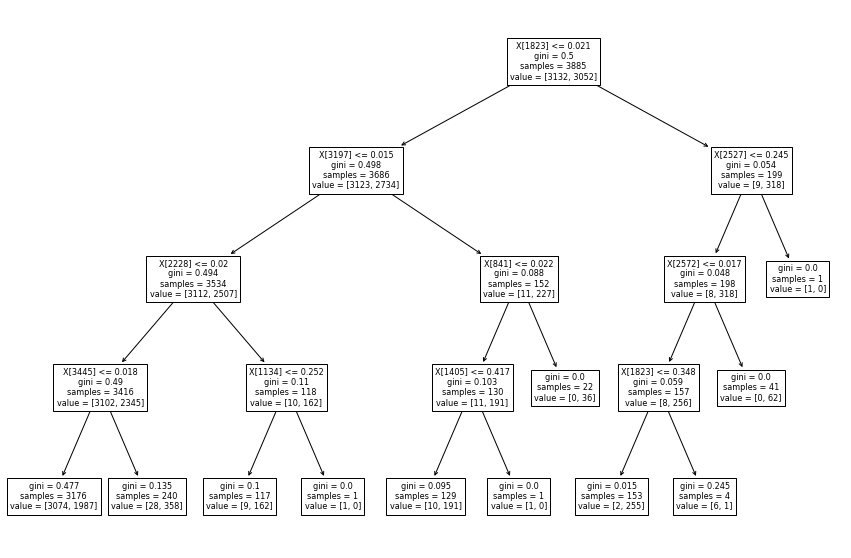

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
tree = RandomForestClassifier(max_depth=4, n_estimators=150)
tree.fit(train_x_vectors, y_train)
#plotting the tree figure
fig = plt.figure(figsize=(15, 10))
plot_tree(tree.estimators_[0])
# accuracy
print(tree.score(test_x_vectors, y_test))
y_pred = tree.predict(test_x_vectors)
f1 = f1_score(y_test, y_pred)
# f1-score
print (f'F1 : {f1}')


### Impementation of the 'XGBoost' Model for Stress Detection using the lib *xgboost*

In [ ]:
import xgboost as xgb

xgb_train = xgb.DMatrix(train_x_vectors, y_train)
xgb_test = xgb.DMatrix(test_x_vectors, y_test)

param = {'eta': 0.6,
         'max_depth': 20,
         'objective': 'binary:logistic'}

xgb_model = xgb.train(param, xgb_train, num_boost_round = 200)
y_pred = xgb_model.predict(xgb_test)
y_pred = np.where(np.array(y_pred) > 0.5, 1, 0) 

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9463477698771816
0.9441829186281102
